In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.processors.altimeter import Altimeter
from mmwave_radar_processing.processors.velocity_estimator import VelocityEstimator
from mmwave_radar_processing.processors.range_resp import RangeProcessor
from mmwave_radar_processing.plotting.plotter_odometry_data import PlotterOdometryData
from mmwave_radar_processing.plotting.movies_odometry import MovieGeneratorOdometry

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz.cfg") #6843_RadVel_ods_20Hz or 1843_RadVel_20Hz
cfg_manager.load_cfg(cfg_path,
                     array_geometry="standard",
                     array_direction="out")  # "down" for downward sensing, "out" for outward sensing
cfg_manager.compute_radar_perforance(profile_idx=0)
print(f"Radar Range Resolution: {cfg_manager.range_res_m:.4f} m")

dataset_name = "CPSL_RadVel_10Hz_forward_backward" #CPSL_RadVel_ods_20Hz_1 or CPSL_RadVel_20Hz_1
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

Radar Range Resolution: 0.0625 m
/data/RadVel/CPSL_RadVel_10Hz_forward_backward
found 365 radar samples
did not find lidar samples
found 365 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 365 vehicle velocity samples
found 365 vehicle odometry samples


In [3]:
plotter = PlotterOdometryData(config_manager=cfg_manager)
plotter.min_threshold_dB = 70

altimeter = Altimeter(
    config_manager=cfg_manager,
    min_altitude_m=1.0, #15.0e-2 for ods, 40.0e-2 for standard
    zoom_search_region_m=50.0e-2, #20.0 e-2 for ods, 50.0e-2 for standard
    altitude_search_limit_m=3.0, #20.0 e-2 for ods, 50.0e-2 for standard
    range_bias=0.0 #-0.13 for ods, 0.0 for standard
)

velocity_estimator = VelocityEstimator(
    config_manager=cfg_manager,
    lower_range_bound=0.1,
    upper_range_bound=0.5,
    precise_vel_bound=0.5,#0.20
    peak_threshold_dB=70.0,
    min_R2_threshold=0.25
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)


In [4]:
#initialize the movie generator
movie_generator = MovieGeneratorOdometry(
    cpsl_dataset=dataset,
    plotter=plotter,
    altimeter=altimeter,
    velocity_estimator=velocity_estimator,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

found temp dir: /home/david/Downloads/RadVel/CPSL_RadVel_10Hz_forward_backward
clearing temp directory /home/david/Downloads/RadVel/CPSL_RadVel_10Hz_forward_backward


  0%|          | 0/365 [00:00<?, ?it/s]

100%|██████████| 365/365 [00:15<00:00, 23.53it/s]


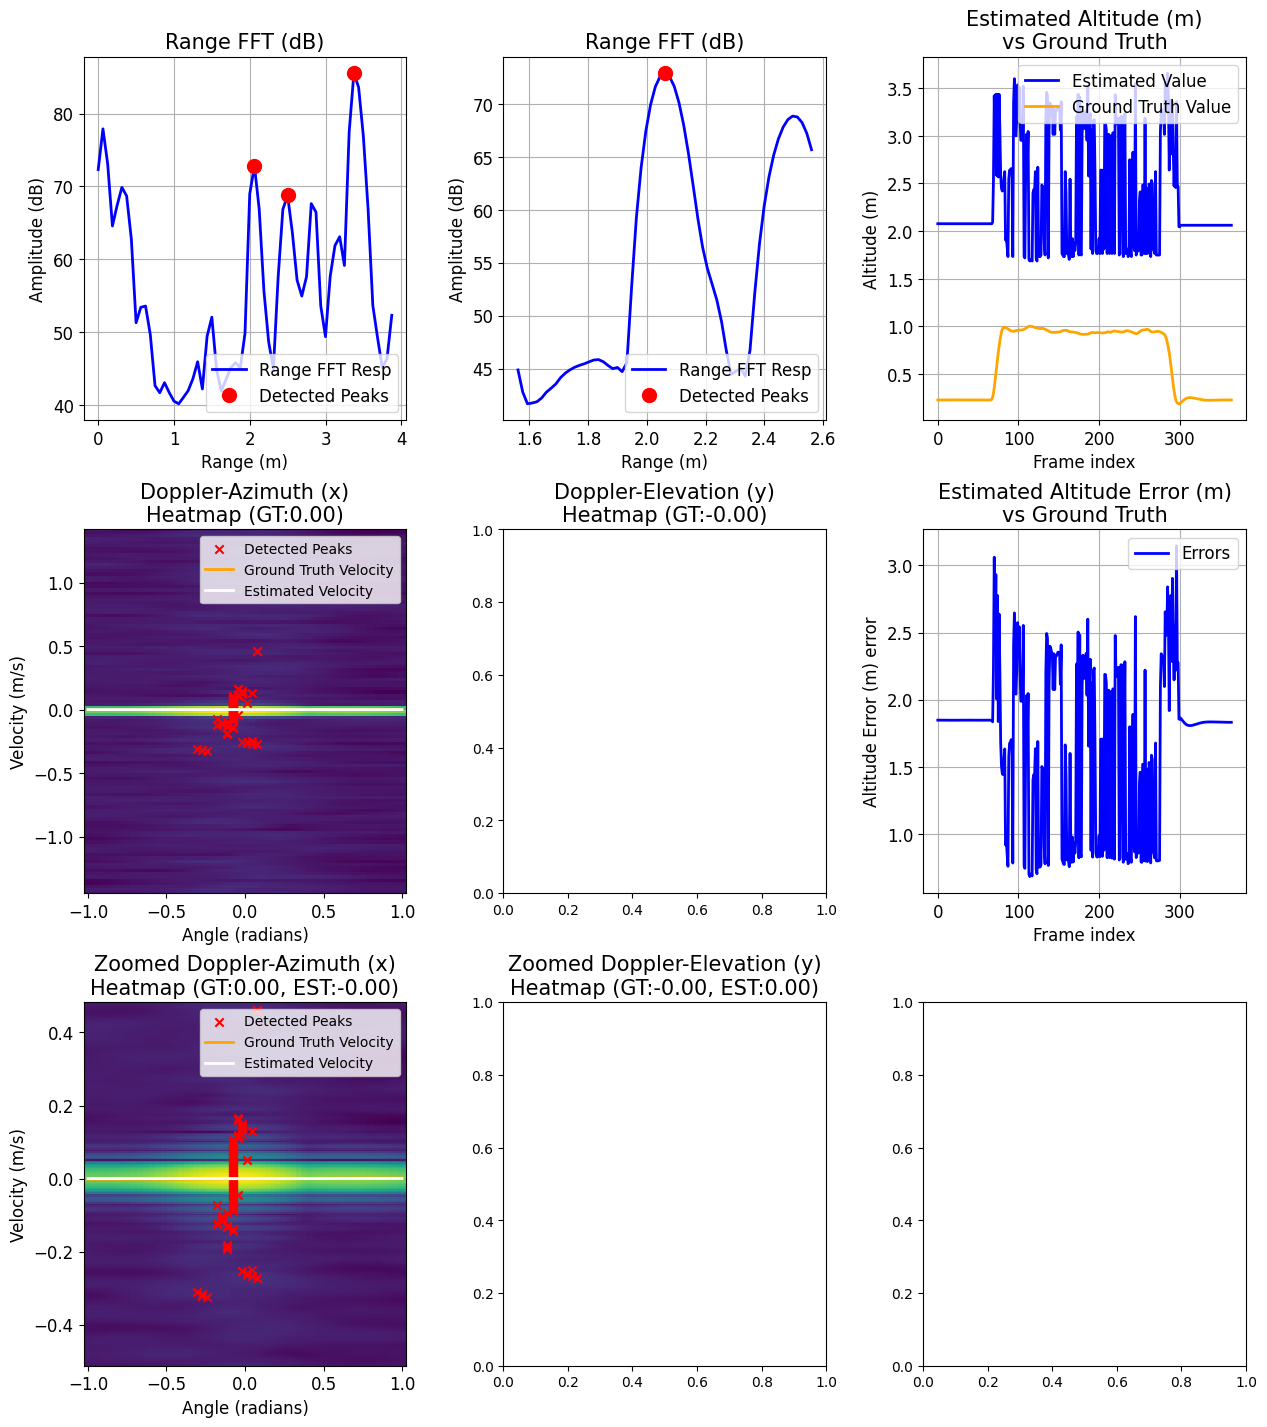

In [5]:
#for getting access to the adc cube
#good frames: 100 - takeoff 7- on ground 310 - moving
idx=dataset.num_frames#80#7#310#dataset.num_frames
altimeter.reset()
velocity_estimator.reset()
hist_test = []
#compute responses over a series of frames
#get the ADC cube

for i in tqdm(range(idx)):
    adc_cube = dataset.get_radar_data(i)
    adc_cube = virtual_array_reformatter.process(adc_cube)

    #estimate the altitude
    est_altitude = altimeter.process(adc_cube=adc_cube, precise_est_enabled=True)
    
    #save the altitude history
    vehicle_odom = dataset.get_vehicle_odom_data(idx=i)
    gt_altitude = np.average(vehicle_odom[:, 3])
    altimeter.update_history(
        estimated=np.array([est_altitude]),
        ground_truth=np.array([gt_altitude])
    )


    #estimate the velocity
    vel_est = velocity_estimator.process(
        adc_cube=adc_cube,
        altitude=est_altitude,
        enable_precise_responses=True)
    
    #save the gt velocity history
    vehicle_vel_x = np.average(vehicle_odom[:,8])
    vehicle_vel_y = np.average(vehicle_odom[:,9])
    vehicle_vel_z = np.average(vehicle_odom[:,10])
    velocity_estimator.update_history(
        ground_truth=np.array([vehicle_vel_x,vehicle_vel_y,vehicle_vel_z]),
        estimated=vel_est
    )
    hist_test.append(vel_est)

    try:
        camera_view = dataset.get_camera_frame(i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(3,3, figsize=(15,17))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    altimeter=altimeter,
    velocity_estimator=velocity_estimator,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    axs=axs,
    show=True
)

alpha: 3.6337234675916292 (mag), 11.20703747392199 dB


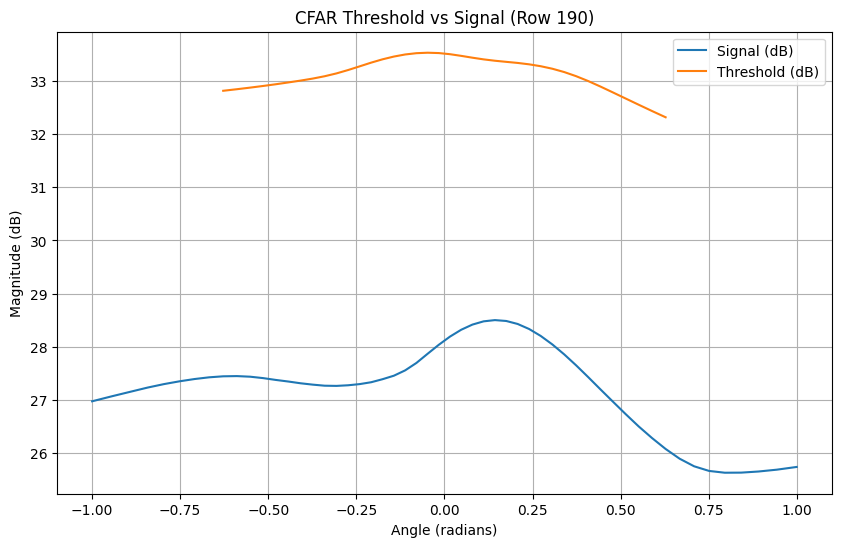

In [6]:
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D
from scipy.signal import convolve2d

zoomed_doppler_azimuth_resp_mag = velocity_estimator.precise_azimuth_response_mag
doppler_azimuth_resp_mag = velocity_estimator.azimuth_response_mag

ca_cfar = CaCFAR_1D(
    num_guard_cells=4,
    num_training_cells=4,
    false_alarm_rate=0.05
)

#test cfar algorithm out (zoomed doppler azimuth response)
signal = np.abs(zoomed_doppler_azimuth_resp_mag)
row_bins = velocity_estimator.zoomed_vel_bins
col_bins = velocity_estimator.valid_angle_bins

P_n = (1/ca_cfar.N) * convolve2d(signal,ca_cfar.window, mode='valid')
T =  ca_cfar.alpha * P_n

invalid_region_size = ca_cfar.num_training_cells + ca_cfar.num_guard_cells
valid_idxs = np.ones(signal.shape[1], dtype=bool)
valid_idxs[:invalid_region_size] = False
valid_idxs[-invalid_region_size:] = False
valid_col_bins = col_bins[invalid_region_size:-invalid_region_size]

# Detect targets
det_idxs = signal[:, invalid_region_size:-invalid_region_size] > T

# Plot signal and threshold for a given row
row_index = 190  # Example row index
plt.figure(figsize=(10, 6))
plt.plot(col_bins, 10*np.log10(signal[row_index, :]), label='Signal (dB)')
plt.plot(valid_col_bins, 10*np.log10(T[row_index, :]), label='Threshold (dB)')
plt.xlabel('Angle (radians)')
plt.ylabel('Magnitude (dB)')
plt.title(f'CFAR Threshold vs Signal (Row {row_index})')
plt.legend()
plt.grid(True)
plt.show()

row_bins_expanded = np.repeat(row_bins[:, np.newaxis], det_idxs.shape[1], axis=1)
col_bins_valid = col_bins[invalid_region_size:-invalid_region_size]
det_bins = np.column_stack((row_bins_expanded[det_idxs], col_bins_valid[np.where(det_idxs)[1]]))




In [7]:
velocity_estimator.detect_vel_zero_az_peaks(use_precise_response=False)
ego_vx_estimate = velocity_estimator.estimate_ego_vx_velocity()
print(velocity_estimator.azimuth_peak_zero_az)
print(f"Estimated Ego Velocity: {ego_vx_estimate:.2f} m/s")

#compute the precise response
range_window = velocity_estimator.get_range_window(
    altitude=est_altitude,
    sensing_direction=velocity_estimator.config_manager.array_direction
)
print(f"Range Window: {range_window}")

velocity_estimator.compute_azimuth_response(
    adc_cube=adc_cube,
    range_window=range_window,
    use_precise_fft=True,
    precise_fft_center_vel=-1 * velocity_estimator.ego_vx_estimate
)

velocity_estimator.detect_vel_zero_az_peaks(use_precise_response=True)
ego_vx_estimate = velocity_estimator.estimate_ego_vx_velocity()
print(velocity_estimator.azimuth_peak_zero_az)
print(f"Estimated Ego Velocity: {ego_vx_estimate:.2f} m/s")

velocity_estimator.detect_vel_row_peaks(use_precise_response=True)

velocity_estimator.estimate_ego_velocity()
print(f"Proposed Ego Velocity: {velocity_estimator.proposed_velocity_estimate} m/s")

[ 0.         -0.01255776]
Estimated Ego Velocity: 0.01 m/s
Range Window: [1.         3.93477601]
[0.     0.0001]
Estimated Ego Velocity: -0.00 m/s
Proposed Ego Velocity: [-1.00000000e-04 -3.13445908e+00  0.00000000e+00] m/s


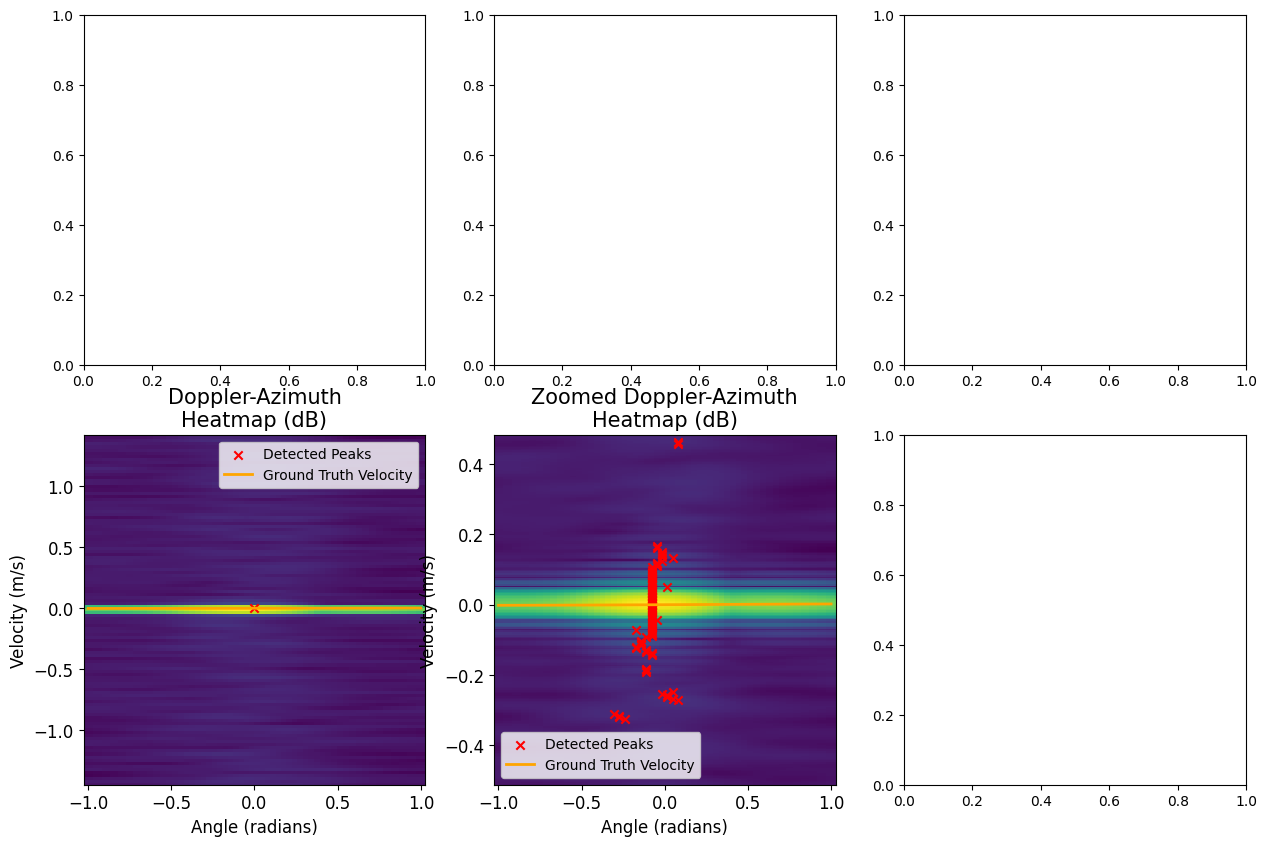

In [8]:
#get the peaks
fig,axs=plt.subplots(nrows=2,ncols=3, figsize=(15,10))

if velocity_estimator.config_manager.array_geometry == "ods":
    plotter.plot_doppler_az_resp(
        resp=velocity_estimator.elevation_response_mag,
        doppler_azimuth_processor=velocity_estimator,
        peaks=np.array([velocity_estimator.elevation_peak_zero_az]),
        convert_to_dB=True,
        vd_ground_truth=velocity_estimator.get_gt_velocity_measurement_predictions(direction="elevation"),
        ax=axs[0,0],
        show=False
    )

    plotter.plot_zoomed_doppler_az_resp(
        resp=velocity_estimator.precise_elevation_response_mag,
        doppler_azimuth_processor=velocity_estimator,
        peaks=velocity_estimator.elevation_peaks,
        convert_to_dB=True,
        vd_ground_truth=velocity_estimator.get_gt_velocity_measurement_predictions(direction="elevation"),
        ax=axs[0,1],
        show=False
    )

plotter.plot_doppler_az_resp(
    resp=velocity_estimator.azimuth_response_mag,
    doppler_azimuth_processor=velocity_estimator,
    peaks=np.array([velocity_estimator.azimuth_peak_zero_az]),
    convert_to_dB=True,
    vd_ground_truth=velocity_estimator.get_gt_velocity_measurement_predictions(direction="azimuth"),
    ax=axs[1,0],
    show=False
)

plotter.plot_zoomed_doppler_az_resp(
    resp=velocity_estimator.precise_azimuth_response_mag,
    doppler_azimuth_processor=velocity_estimator,
    peaks=velocity_estimator.azimuth_peaks,
    convert_to_dB=True,
    vd_ground_truth=velocity_estimator.get_gt_velocity_measurement_predictions(direction="azimuth"),
    ax=axs[1,1],
    show=False
)

plt.show()

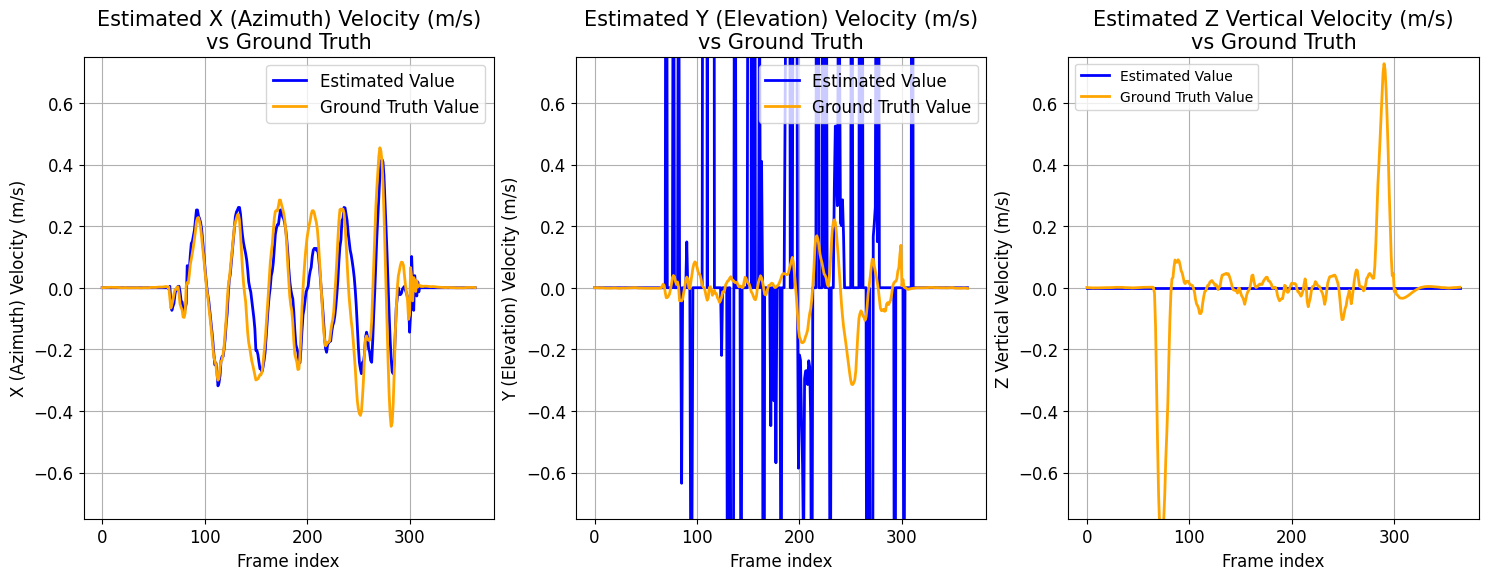

In [9]:
#comparing azimuth performance
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)
r2_statistics = np.stack(velocity_estimator.history_R2_statistics,axis=0)

fig,ax = plt.subplots(1,3,figsize=(18,6))

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,0],
    ground_truth=vel_gt[:,0],
    value_label="X (Azimuth) Velocity (m/s)",
    ax=ax[0],
    show=False
)
ax[0].set_ylim([-0.75,0.75])

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,1],
    ground_truth=vel_gt[:,1],
    value_label="Y (Elevation) Velocity (m/s)",
    ax=ax[1],
    show=False
)
ax[1].set_ylim([-0.75,0.75])

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,2],
    ground_truth=-1 * vel_gt[:,2], #TODO: Fix this
    value_label="Z Vertical Velocity (m/s)",
    ax=ax[2],
    show=False
)
ax[2].set_ylim([-0.75,0.75])

# ax.plot(residuals[:,1],label="Elevation Residuals")
plt.legend()
plt.show()

Summary Statistics of Velocity Estimation Errors:
             Mean    Median      RMSE
X Error  0.047503  0.017835  0.079963
Y Error  0.414613  0.021083  1.045764
Z Error  0.058577  0.012757  0.160473




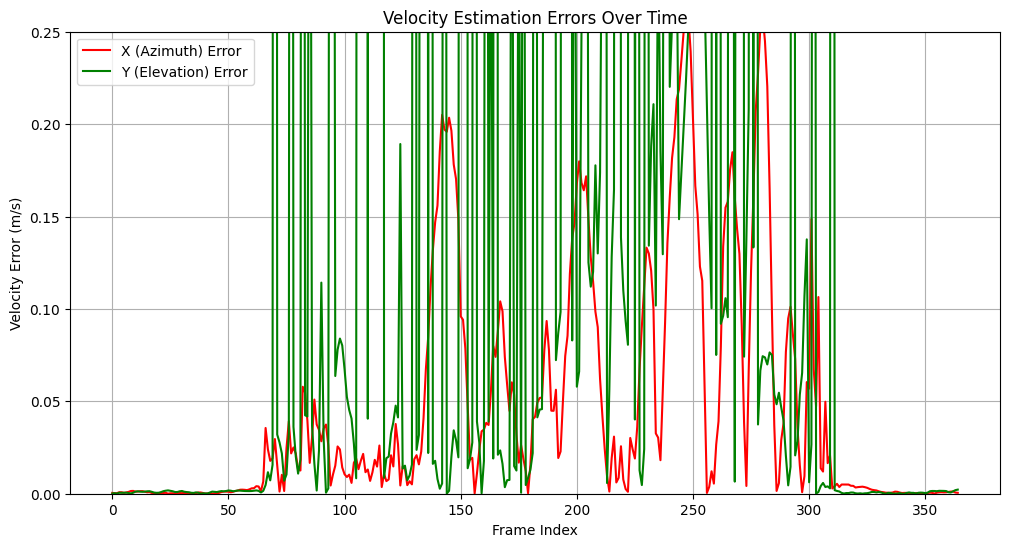

In [11]:
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

#calculate absolute errors
x_errors = np.abs(vel_est[:,0] - vel_gt[:,0])
y_errors = np.abs(vel_est[:,1] - vel_gt[:,1])
z_errors = np.abs(vel_est[:,2] - -1 * vel_gt[:,2]) #TODO: Fix this

#calculate overall errors
# x_errors = vel_est[:,0] - vel_gt[:,0]
# y_errors = vel_est[:,1] - vel_gt[:,1]
# z_errors = vel_est[:,2] - -1 * vel_gt[:,2] #TODO: Fix this

# Calculate summary statistics using pandas
errors_df = pd.DataFrame({
    "X Error": x_errors,
    "Y Error": y_errors,
    "Z Error": z_errors
})

summary_stats = pd.DataFrame({
    "Mean": errors_df.mean(),
    "Median": errors_df.median(),
    "RMSE": np.sqrt((errors_df ** 2).mean())
})

print("Summary Statistics of Velocity Estimation Errors:")
print(summary_stats.to_string())
print("\n")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_errors, label="X (Azimuth) Error", color="red")
ax.plot(y_errors, label="Y (Elevation) Error", color="green")
# ax.plot(z_errors, label="Z Vertical Error", color="blue")

ax.set_xlabel("Frame Index")
ax.set_ylabel("Velocity Error (m/s)")
ax.set_title("Velocity Estimation Errors Over Time")
ax.legend()
ax.grid(True)
plt.ylim([0,0.25])
plt.show()

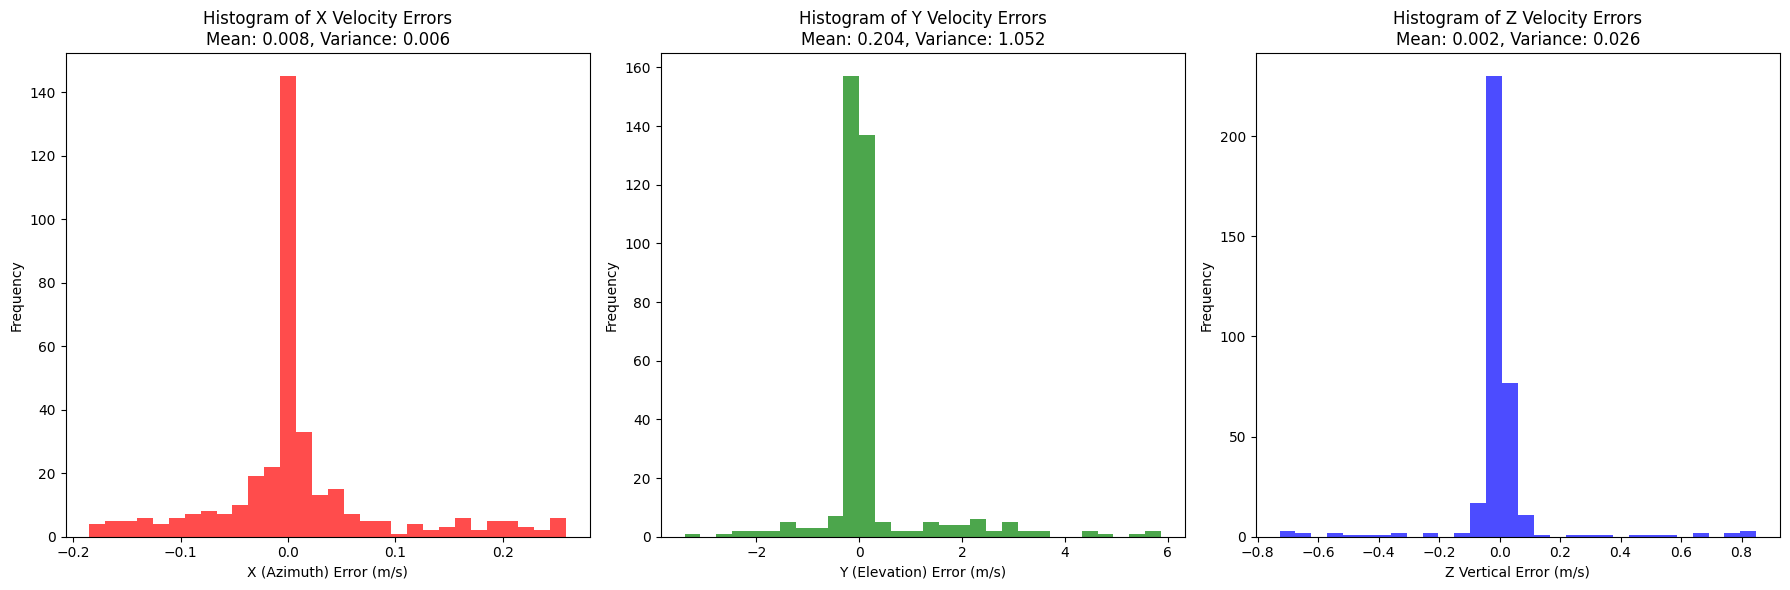

In [12]:
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

x_errors = vel_est[:,0] - vel_gt[:,0]
y_errors = vel_est[:,1] - vel_gt[:,1]
z_errors = vel_est[:,2] - -1 * vel_gt[:,2] #TODO: Fix this

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Calculate mean and variance for X errors
x_mean = np.mean(x_errors)
x_variance = np.var(x_errors)
axs[0].hist(x_errors, bins=30, color='red', alpha=0.7)
axs[0].set_xlabel("X (Azimuth) Error (m/s)")
axs[0].set_ylabel("Frequency")
axs[0].set_title(f"Histogram of X Velocity Errors\nMean: {x_mean:.3f}, Variance: {x_variance:.3f}")

# Calculate mean and variance for Y errors
y_mean = np.mean(y_errors)
y_variance = np.var(y_errors)
axs[1].hist(y_errors, bins=30, color='green', alpha=0.7)
axs[1].set_xlabel("Y (Elevation) Error (m/s)")
axs[1].set_ylabel("Frequency")
axs[1].set_title(f"Histogram of Y Velocity Errors\nMean: {y_mean:.3f}, Variance: {y_variance:.3f}")

# Calculate mean and variance for Z errors
z_mean = np.mean(z_errors)
z_variance = np.var(z_errors)
axs[2].hist(z_errors, bins=30, color='blue', alpha=0.7)
axs[2].set_xlabel("Z Vertical Error (m/s)")
axs[2].set_ylabel("Frequency")
axs[2].set_title(f"Histogram of Z Velocity Errors\nMean: {z_mean:.3f}, Variance: {z_variance:.3f}")

plt.tight_layout()
plt.show()

Error Metric    Value
  Mean Error 0.354104
Median Error 0.299019
  RMSE Error 0.456319




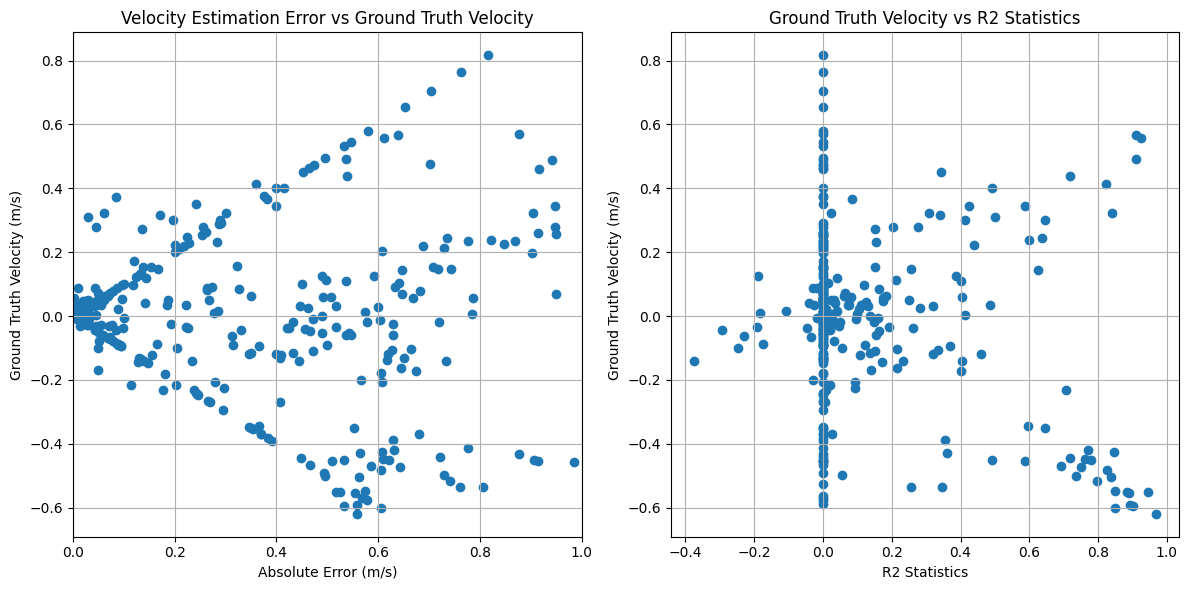

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

x_vel_est_az = vel_est[:,0]
x_vel_gt_az = vel_gt[:,1]
x_vel_est_el = vel_est[:,1]
x_vel_gt_el = vel_gt[:,0]

errors_az = np.abs(x_vel_est_az - x_vel_gt_az)
errors_el = np.abs(x_vel_est_el - x_vel_gt_el)

r2_statistics = np.stack(velocity_estimator.history_R2_statistics,axis=0)
az_residuals = r2_statistics[:,0]
el_residuals = r2_statistics[:,1]

errors = np.concatenate([errors_az, errors_el])
vel_gt = np.concatenate([x_vel_gt_az, x_vel_gt_el])
r2_statistics = np.concatenate([az_residuals, el_residuals])

# errors = errors_az
# x_vel_gt = x_vel_gt_az

# Calculate mean, median, and RMSE
mean_error = np.mean(errors)
median_error = np.median(errors)
rmse_error = np.sqrt(np.mean(errors ** 2))

# Create a Pandas DataFrame for the table
table_data = {
    "Error Metric": ["Mean Error", "Median Error", "RMSE Error"],
    "Value": [mean_error, median_error, rmse_error]
}
table = pd.DataFrame(table_data)

print(table.to_string(index=False))
print("\n")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of errors vs ground truth
axs[0].scatter(errors, vel_gt)
axs[0].set_xlabel("Absolute Error (m/s)")
axs[0].set_ylabel("Ground Truth Velocity (m/s)")
axs[0].set_title("Velocity Estimation Error vs Ground Truth Velocity")
axs[0].grid(True)
axs[0].set_xlim(0,1)

# Scatter plot of ground truth vs residuals
axs[1].scatter(r2_statistics, vel_gt)
axs[1].set_xlabel("R2 Statistics")
axs[1].set_ylabel("Ground Truth Velocity (m/s)")
axs[1].set_title("Ground Truth Velocity vs R2 Statistics")
axs[1].grid(True)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'R2 Statistics Over Time')

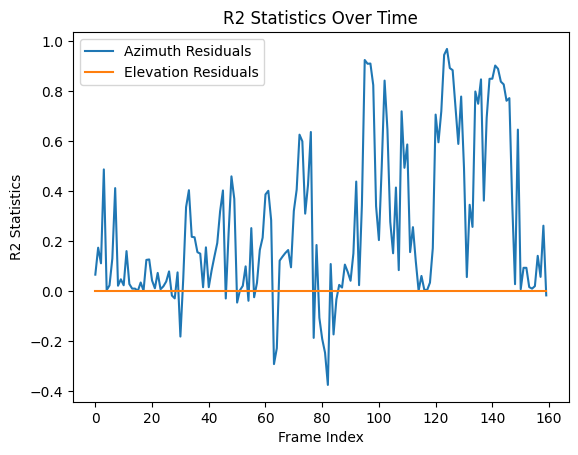

In [85]:
r2_statistics = np.stack(velocity_estimator.history_R2_statistics,axis=0)
plt.plot(r2_statistics[:,0],label="Azimuth Residuals")
plt.plot(r2_statistics[:,1],label="Elevation Residuals")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("R2 Statistics")
plt.title("R2 Statistics Over Time")

 19%|█▉        | 31/160 [00:15<01:03,  2.04it/s]/home/david/Documents/mmwave_radar_processing/mmwave_radar_processing/plotting/plotter_mmWave_data.py:425: RuntimeWarning: divide by zero encountered in log10
  resp = 20 * np.log10(resp)
100%|██████████| 160/160 [00:17<00:00,  9.12it/s]


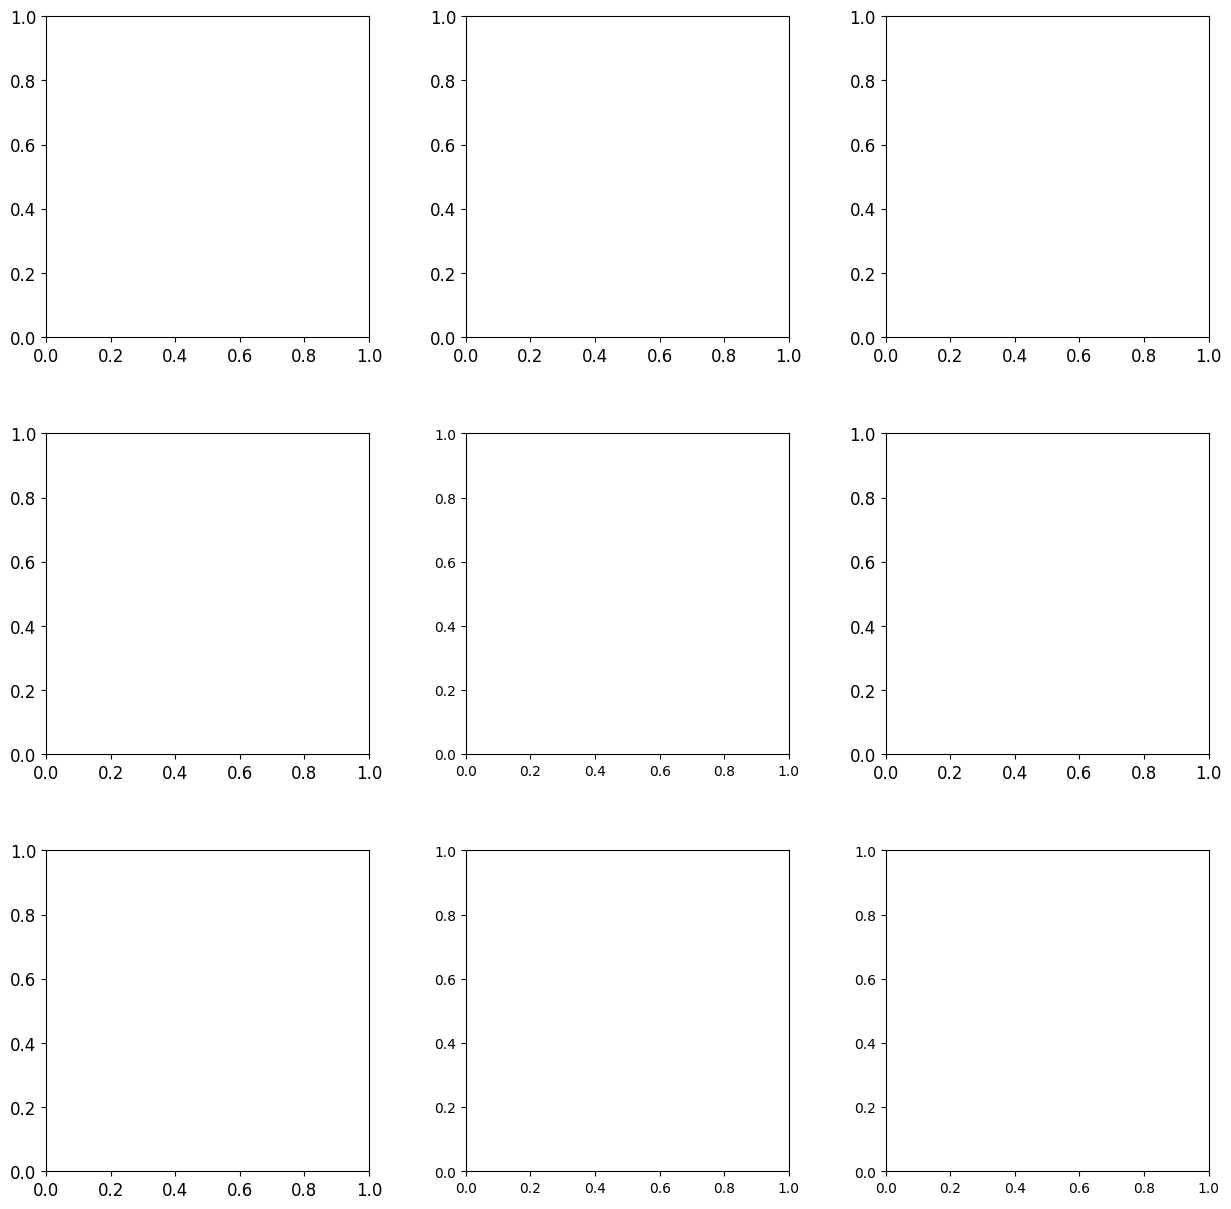

In [9]:
movie_generator.initialize_figure(nrows=3,ncols=3,figsize=(15,15))

altimeter.reset()
velocity_estimator.reset()

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True
)
fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_altitude.mp4".format(dataset_name),fps=fps)